In [1]:
import os
import numpy as np
import pandas as pd
import nitools as nt
import nibabel as nb
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from IPython.display import Image

from pathlib import Path
from SUITPy import flatmap

import selective_recruitment.plotting as plotting
import selective_recruitment.recruite_ana as ra
import selective_recruitment.globals as gl
import selective_recruitment.scripts.script_prep_sc as ss
import selective_recruitment.scripts.script_roi_pairs_IBC as rp


from statsmodels.stats.anova import AnovaRM # perform F test
import warnings

In [2]:
# setting working directory 
# wkdir = '/Volumes/diedrichsen_data$/data/Cerebellum/Demand/selective_recruit'
langdir = 'A:\data\Cerebellum\Language'
if not Path(langdir).exists():
    langdir = '/cifs/diedrichsen/data/Cerebellum/Language/'



In [6]:
label_dict={'rest':'rest',
            'Prediction': 'Prediction', 
            'PredictViol':'PredictViol',
            'PredictScram':'PredictScram',
            }

# Across whole

In [4]:
# D = ra.get_summary(dataset = "MDTB", 
#                 ses_id = 'ses-s2', 
#                 type = "CondAll", 
#                 cerebellum_roi = None, 
#                 cortex_roi = None,
#                 add_rest = True)
# D = ra.run_regress(D,fit_intercept=True)
# D.to_csv(langdir + '/MDTB/ROI_all_MDTB-S2.tsv',sep='\t')


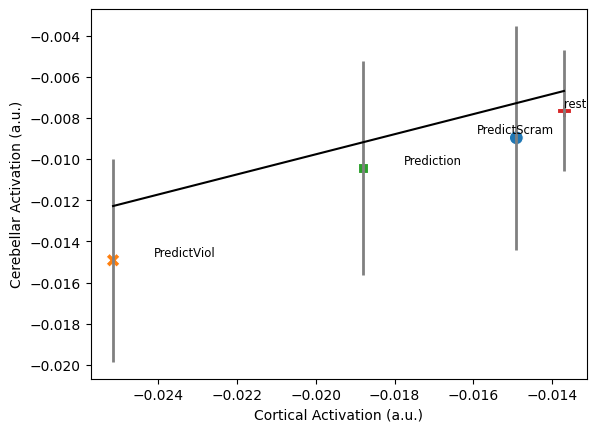

In [18]:
df_path = os.path.join(langdir, 'MDTB', "ROI_all_MDTB-S2.tsv")
df = pd.read_csv(df_path, sep="\t")
conditions = ['Prediction','PredictViol','PredictScram', 'rest']
df_filtered = df[df['cond_name'].isin(conditions)]
plotting.make_scatterplot(df_filtered,split='cond_name', markers= True, labels = label_dict)

In [19]:
# need to pass 
print(AnovaRM(data=df_filtered[df_filtered.cond_name!='rest'], depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  0.0725 2.0000 46.0000 0.9302



# Language roi (nettekoven S1L-S4L)

In [9]:
# D = ra.get_summary(dataset = "MDTB", 
#                 ses_id = 'ses-s2', 
#                 type = "CondAll", 
#                 cerebellum_roi = 'tpl-SUIT/atl-language(S1L-S4L)_NettekovenSym68c32_space-SUIT', 
#                 cortex_roi = 'tpl-fs32k/language(S1L-S4L)_NettekovenSym68c32.32k',
#                 add_rest = True)
# D = ra.run_regress(D,fit_intercept=True)
# D.to_csv(langdir + '/MDTB/ROI_nettekoven(S1L-S4L)_MDTB-S2.tsv',sep='\t')

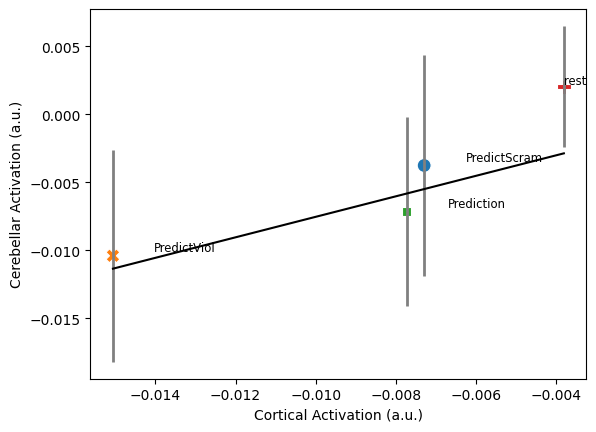

In [17]:
df_path = os.path.join(langdir, 'MDTB', "ROI_nettekoven(S1L-S4L)_MDTB-S2.tsv")
df = pd.read_csv(df_path, sep="\t")
conditions = ['Prediction','PredictViol','PredictScram', 'rest']
df_filtered = df[df['cond_name'].isin(conditions)]
plotting.make_scatterplot(df_filtered,split='cond_name', markers= True, labels = label_dict)

In [11]:
# need to pass 
print(AnovaRM(data=df_filtered[df_filtered.cond_name!='rest'], depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  0.1567 2.0000 46.0000 0.8554



# Language roi (nettekoven S1R-S4R)

In [12]:
# D = ra.get_summary(dataset = "MDTB", 
#                 ses_id = 'ses-s2', 
#                 type = "CondAll", 
#                 cerebellum_roi = 'tpl-SUIT/atl-language(S1R-S4R)_NettekovenSym68c32_space-SUIT', 
#                 cortex_roi = 'tpl-fs32k/language(S1R-S4R)_NettekovenSym68c32.32k',
#                 add_rest = True)
# D = ra.run_regress(D,fit_intercept=True)
# D.to_csv(langdir + '/MDTB/ROI_nettekoven(S1R-S4R)_MDTB-S2.tsv',sep='\t')

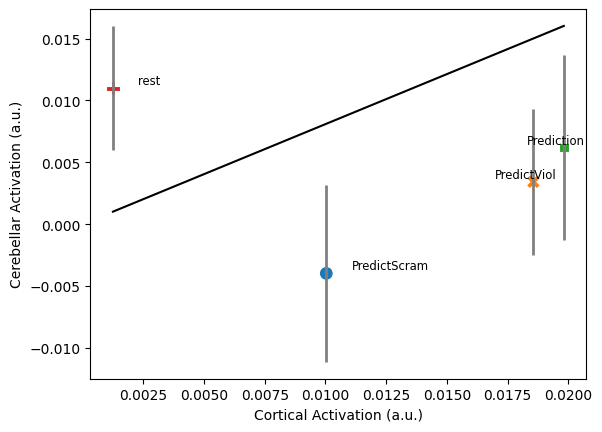

In [16]:
df_path = os.path.join(langdir, 'MDTB', "ROI_nettekoven(S1R-S4R)_MDTB-S2.tsv")
df = pd.read_csv(df_path, sep="\t")
conditions = ['Prediction','PredictViol','PredictScram', 'rest']
df_filtered = df[df['cond_name'].isin(conditions)]
plotting.make_scatterplot(df_filtered,split='cond_name', markers= True, labels = label_dict)

In [15]:
# need to pass 
print(AnovaRM(data=df_filtered[df_filtered.cond_name!='rest'], depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  0.5179 2.0000 46.0000 0.5992

